#Imports Libraries

In [1]:
!pip -q install numpy pandas matplotlib scikit-learn xgboost shap tqdm tensorflow

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import shap
import tensorflow as tf
from tqdm import tqdm

SETTINGS And Data Load

In [2]:
plt.rcParams["figure.dpi"] = 120

# -----------------------------
# 0) SETTINGS
# -----------------------------
DATA_PATH = "/content/drive/MyDrive/ENERGY_CONSUMPTION /CLEAN_House.csv"   # <-- change if needed
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Speed/quality knobs (safe defaults for 500MB)
CHUNKSIZE = 500_000
RESAMPLE_RULE = "1min"
HORIZON_MIN = 1
MAX_LAG = 30              # increase to 60 if you have time/RAM
APPLIANCES_FOR_FEATURES = 9  # set 5 for faster, 9 for richer
RUN_FEDERATED = True      # set False if you want fastest
FL_ROUNDS = 6
FL_LOCAL_EPOCHS = 1

CHUNKED LOAD + RESAMPLE

In [3]:
usecols = [
    "Time","Aggregate",
    "Appliance1","Appliance2","Appliance3","Appliance4","Appliance5",
    "Appliance6","Appliance7","Appliance8","Appliance9","Issues"
]

def load_resample_chunked(csv_path, chunksize=500_000, rule="1min"):
    agg_list = []
    for chunk in tqdm(pd.read_csv(csv_path, usecols=usecols, chunksize=chunksize),
                      desc="Loading chunks"):
        chunk["Time"] = pd.to_datetime(chunk["Time"], errors="coerce")
        chunk = chunk.dropna(subset=["Time"])
        chunk = chunk[chunk["Issues"] == 0].copy()
        if len(chunk) == 0:
            continue
        chunk = chunk.set_index("Time").sort_index()
        chunk_rs = chunk.resample(rule).mean(numeric_only=True)
        agg_list.append(chunk_rs)

    if not agg_list:
        raise ValueError("No data loaded after filtering Issues==0. Check file/columns.")

    df_rs = pd.concat(agg_list).groupby(level=0).mean()
    df_rs = df_rs.dropna(subset=["Aggregate"])
    return df_rs

print("Chunk-loading + resampling (RAM-safe)...")
df_1min = load_resample_chunked(DATA_PATH, chunksize=CHUNKSIZE, rule=RESAMPLE_RULE)

print("Resampled shape:", df_1min.shape)
print("Time range:", df_1min.index.min(), "→", df_1min.index.max())
display(df_1min.head())

Chunk-loading + resampling (RAM-safe)...


Loading chunks: 14it [00:28,  2.01s/it]


Resampled shape: (800109, 11)
Time range: 2013-10-09 13:06:00 → 2015-07-10 11:56:00


,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
Time,,,,,,,,,,,
2013-10-09 13:06:00,529.666667,74.333333,0.0,68.666667,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-10-09 13:07:00,543.875000,73.875000,0.0,68.750000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-10-09 13:08:00,578.000000,73.100000,0.0,41.900000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-10-09 13:09:00,638.300000,72.800000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2013-10-09 13:10:00,800.200000,72.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


TABLES: Missing + Descriptive Stats

In [4]:
missing_tbl = (df_1min.isna().mean() * 100).sort_values(ascending=False).to_frame("Missing_%")
desc_tbl = df_1min[["Aggregate"] + [f"Appliance{i}" for i in range(1,10)]].describe().T

display(missing_tbl.head(12))
display(desc_tbl)

missing_tbl.to_csv(f"{OUTPUT_DIR}/missing_values.csv")
desc_tbl.to_csv(f"{OUTPUT_DIR}/descriptive_stats.csv")


,Missing_%
Aggregate,0.0
Appliance1,0.0
Appliance2,0.0
Appliance3,0.0
Appliance4,0.0
Appliance5,0.0
Appliance6,0.0
Appliance7,0.0
Appliance8,0.0
Appliance9,0.0


,count,mean,std,min,25%,50%,75%,max
Aggregate,800109.0,479.603607,768.915850,124.0,186.333333,245.8,449.083333,23969.555556
Appliance1,800109.0,17.238412,31.680119,0.0,0.000000,0.0,0.000000,1104.000000
Appliance2,800109.0,16.355388,22.521523,0.0,0.000000,0.0,45.250000,2094.000000
Appliance3,800109.0,28.941127,35.740299,0.0,0.000000,0.0,69.666667,294.100000
Appliance4,800109.0,1.266839,44.553191,0.0,0.000000,0.0,0.000000,2672.000000
Appliance5,800109.0,9.519669,127.978816,0.0,0.000000,0.0,0.000000,2450.833333
Appliance6,800109.0,10.775403,151.403333,0.0,0.000000,0.0,0.000000,2375.857143
Appliance7,800109.0,2.428483,8.270703,0.0,0.000000,0.0,0.000000,1028.000000
Appliance8,800109.0,5.881324,12.551671,0.0,0.000000,0.0,0.000000,243.555556
Appliance9,800109.0,64.642984,243.157038,0.0,1.000000,1.0,1.000000,2086.888889


FIGURE HELPERS

In [5]:
def savefig(name):
    path = os.path.join(OUTPUT_DIR, name)
    plt.savefig(path, bbox_inches="tight")
    print("Saved:", path)

def plot_ts(series, title, fname, max_points=None):
    s = series.copy()
    if max_points and len(s) > max_points:
        s = s.iloc[:max_points]
    plt.figure(figsize=(14,4))
    plt.plot(s.index, s.values)
    plt.title(title)
    plt.xlabel("Time"); plt.ylabel("Watts")
    plt.tight_layout()
    savefig(fname)
    plt.show()

FIGURES (EDA) — 1..9

Saved: outputs/fig01_week.png


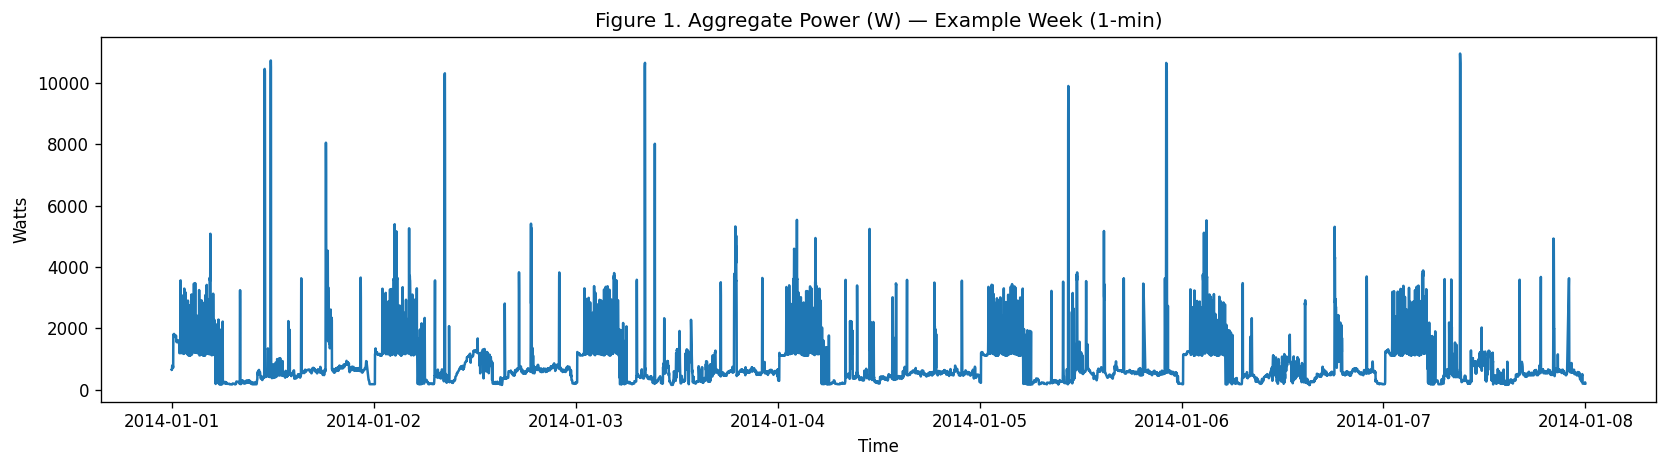

Saved: outputs/fig02_month.png


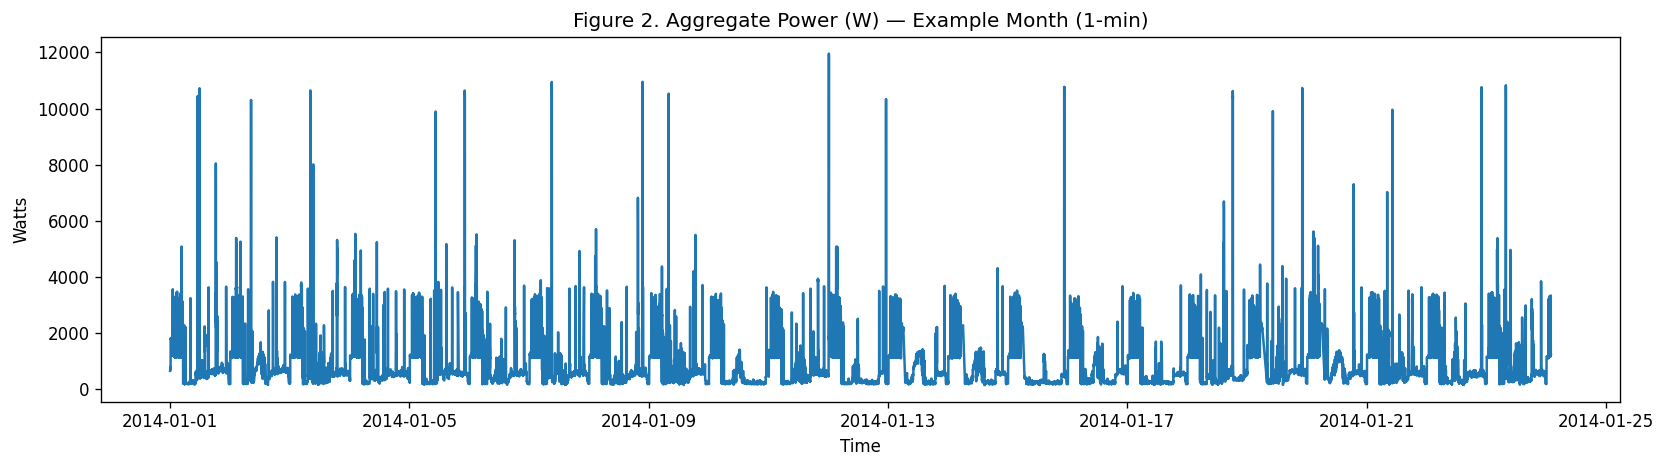

In [6]:
# Figure 1: Example Week
week = df_1min.loc["2014-01-01":"2014-01-07", "Aggregate"]
plot_ts(week, "Figure 1. Aggregate Power (W) — Example Week (1-min)", "fig01_week.png")

# Figure 2: Example Month
month = df_1min.loc["2014-01-01":"2014-01-31", "Aggregate"]
plot_ts(month, "Figure 2. Aggregate Power (W) — Example Month (1-min)", "fig02_month.png")

Saved: outputs/fig03_daily_profile.png


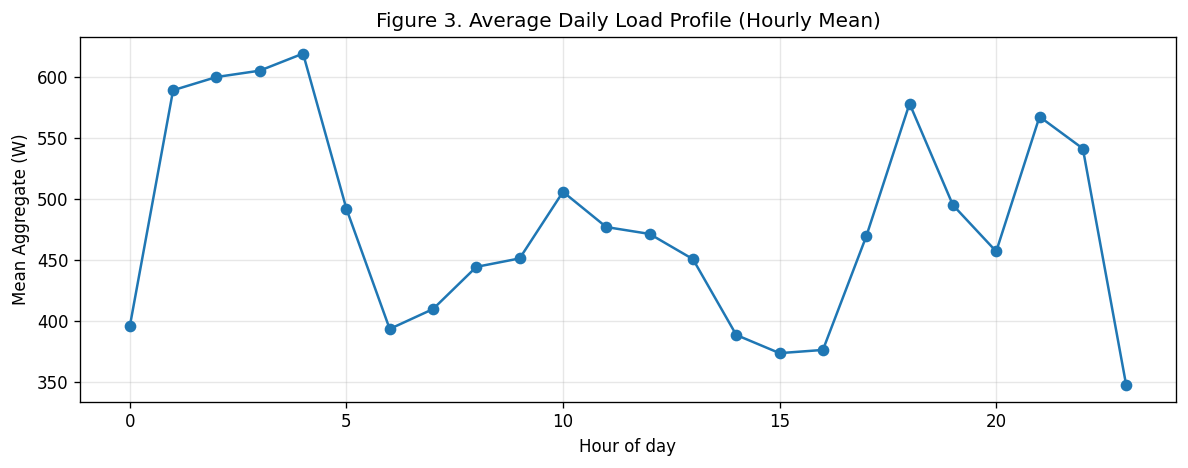

In [7]:
# Figure 3: Average Daily Load Profile (hourly mean)
tmp = df_1min.copy()
tmp["hour"] = tmp.index.hour
hourly_profile = tmp.groupby("hour")["Aggregate"].mean()
plt.figure(figsize=(10,4))
plt.plot(hourly_profile.index, hourly_profile.values, marker="o")
plt.title("Figure 3. Average Daily Load Profile (Hourly Mean)")
plt.xlabel("Hour of day"); plt.ylabel("Mean Aggregate (W)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
savefig("fig03_daily_profile.png")
plt.show()

Saved: outputs/fig04_weekly_profile.png


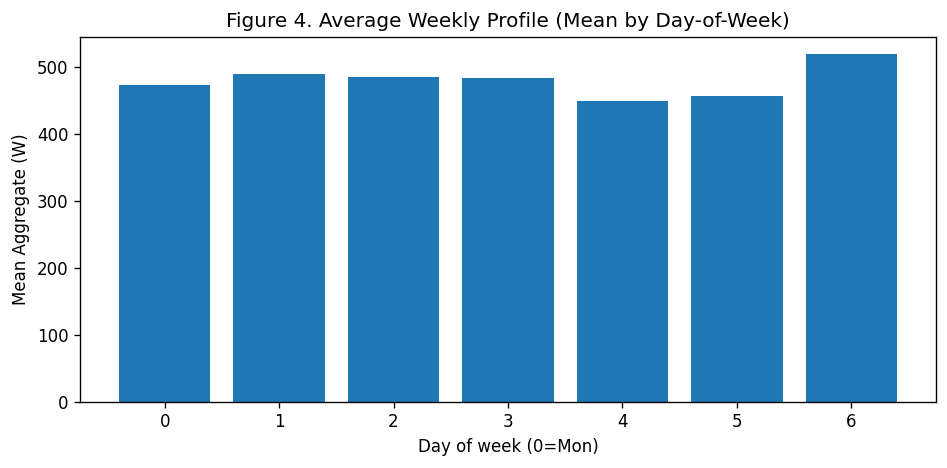

In [8]:
# Figure 4: Average Weekly Profile (day-of-week mean)
tmp["dayofweek"] = tmp.index.dayofweek
dow_mean = tmp.groupby("dayofweek")["Aggregate"].mean()
plt.figure(figsize=(8,4))
plt.bar(dow_mean.index, dow_mean.values)
plt.title("Figure 4. Average Weekly Profile (Mean by Day-of-Week)")
plt.xlabel("Day of week (0=Mon)"); plt.ylabel("Mean Aggregate (W)")
plt.tight_layout()
savefig("fig04_weekly_profile.png")
plt.show()

Saved: outputs/fig05_hist_aggregate.png


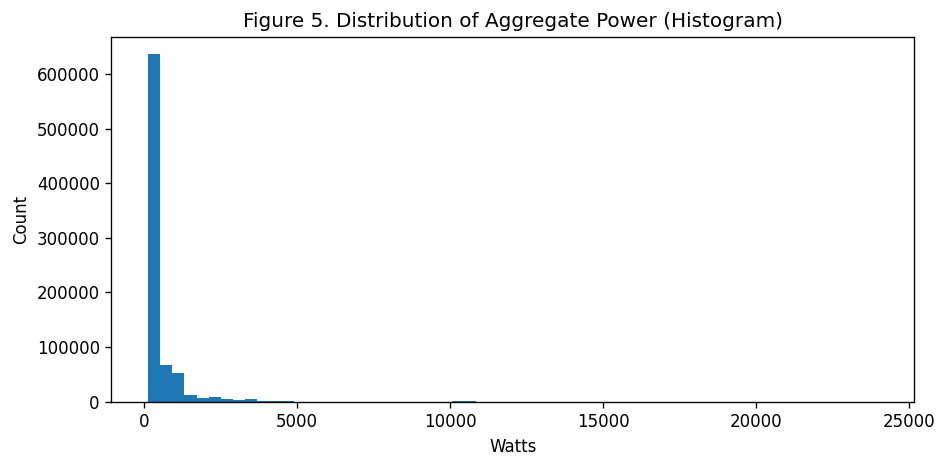

In [9]:
# Figure 5: Histogram (Aggregate)
plt.figure(figsize=(8,4))
vals = df_1min["Aggregate"].clip(lower=0)
plt.hist(vals.values, bins=60)
plt.title("Figure 5. Distribution of Aggregate Power (Histogram)")
plt.xlabel("Watts"); plt.ylabel("Count")
plt.tight_layout()
savefig("fig05_hist_aggregate.png")
plt.show()

Saved: outputs/fig06_boxplot_by_hour.png


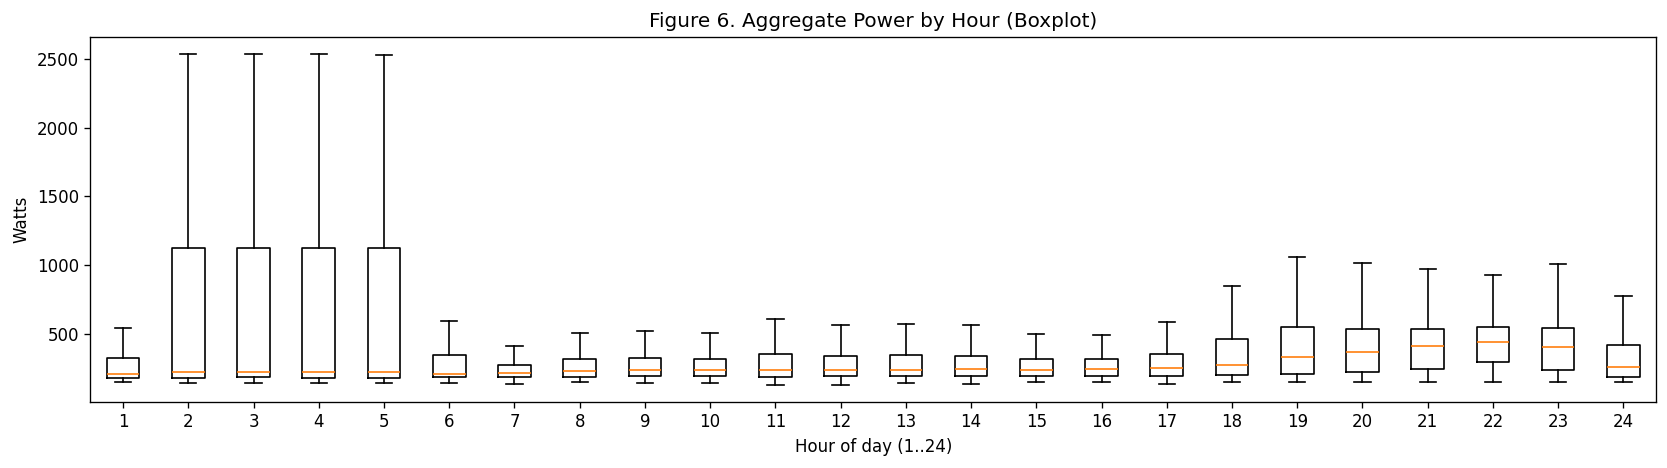

In [10]:
# Figure 6: Boxplot by hour
hour_groups = [df_1min[df_1min.index.hour == h]["Aggregate"].dropna().values for h in range(24)]
plt.figure(figsize=(14,4))
plt.boxplot(hour_groups, showfliers=False)
plt.title("Figure 6. Aggregate Power by Hour (Boxplot)")
plt.xlabel("Hour of day (1..24)"); plt.ylabel("Watts")
plt.tight_layout()
savefig("fig06_boxplot_by_hour.png")
plt.show()

Saved: outputs/fig07_corr_heatmap.png


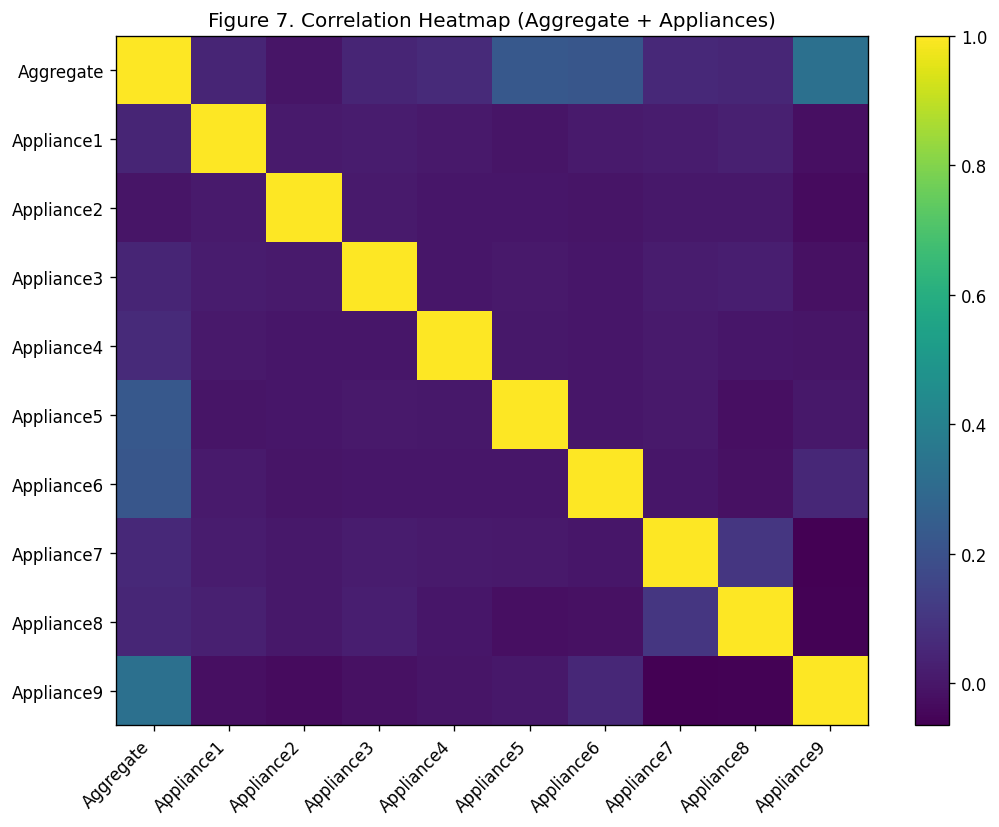

In [11]:
# Figure 7: Correlation heatmap
cols = ["Aggregate"] + [f"Appliance{i}" for i in range(1,10)]
corr = df_1min[cols].corr()
plt.figure(figsize=(9,7))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.yticks(range(len(cols)), cols)
plt.colorbar()
plt.title("Figure 7. Correlation Heatmap (Aggregate + Appliances)")
plt.tight_layout()
savefig("fig07_corr_heatmap.png")
plt.show()

Saved: outputs/fig08_appliance_share.png


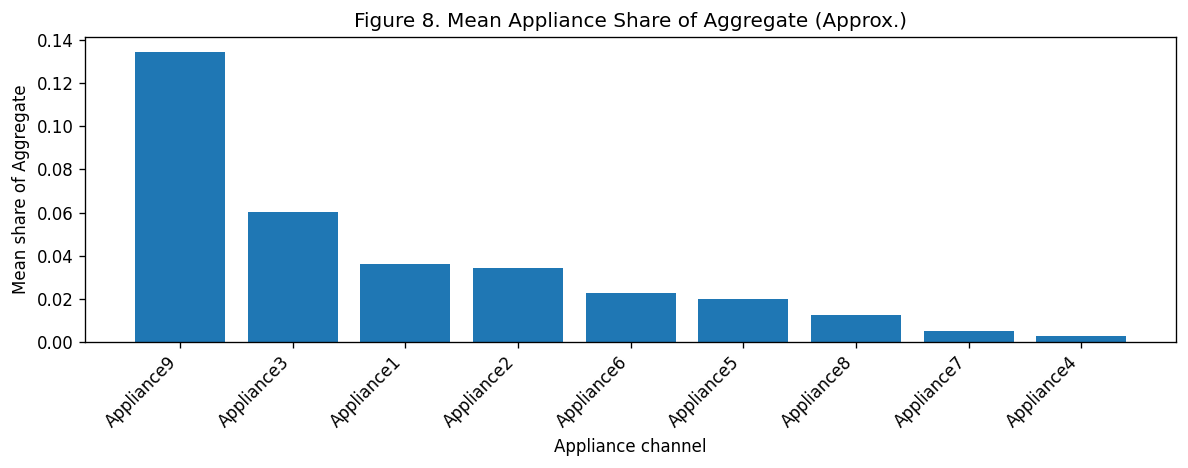

In [12]:
# Figure 8: Appliance mean share (approx contribution)
appliance_means = df_1min[[f"Appliance{i}" for i in range(1,10)]].mean()
aggregate_mean = df_1min["Aggregate"].mean()
share = (appliance_means / max(aggregate_mean, 1e-6)).sort_values(ascending=False)
plt.figure(figsize=(10,4))
plt.bar(share.index, share.values)
plt.title("Figure 8. Mean Appliance Share of Aggregate (Approx.)")
plt.xlabel("Appliance channel"); plt.ylabel("Mean share of Aggregate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
savefig("fig08_appliance_share.png")
plt.show()

Saved: outputs/fig09_lag_correlation.png


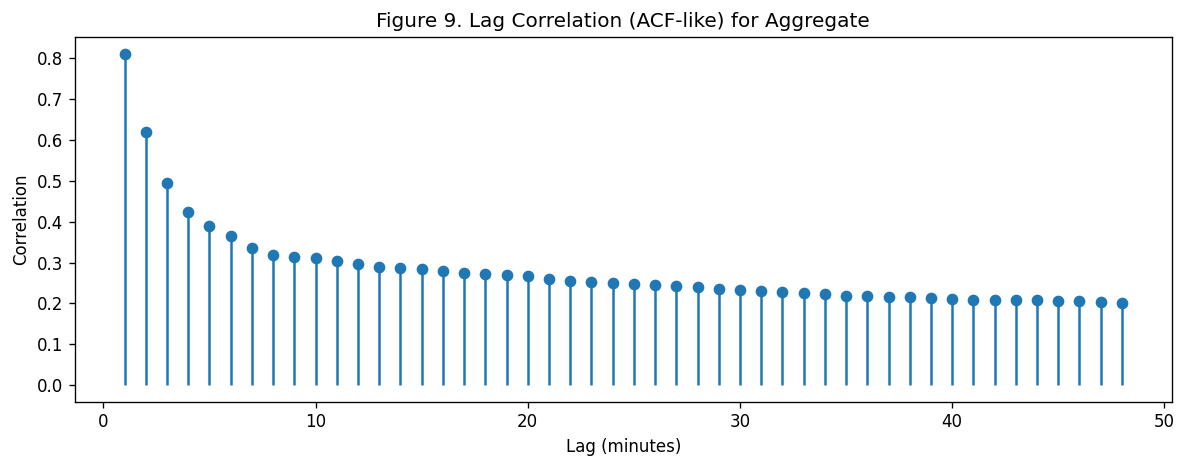

In [13]:
# Figure 9: Lag-correlation plot (Aggregate vs lagged self)
# (quick ACF-like without statsmodels)
max_lag_acf = 48
base = df_1min["Aggregate"].dropna()
acf_vals = []
lags = range(1, max_lag_acf+1)
for lag in lags:
    acf_vals.append(base.corr(base.shift(lag)))
plt.figure(figsize=(10,4))
plt.stem(list(lags), acf_vals, basefmt=" ")
plt.title("Figure 9. Lag Correlation (ACF-like) for Aggregate")
plt.xlabel("Lag (minutes)"); plt.ylabel("Correlation")
plt.tight_layout()
savefig("fig09_lag_correlation.png")
plt.show()

FEATURE ENGINEERING

In [14]:
def make_features(data, target_col="Aggregate", horizon=1, max_lag=30, appliance_n=9):
    d = data.copy()

    # time features
    d["hour"] = d.index.hour
    d["dayofweek"] = d.index.dayofweek
    d["month"] = d.index.month
    d["is_weekend"] = (d["dayofweek"] >= 5).astype(int)

    # lags
    for lag in range(1, max_lag+1):
        d[f"{target_col}_lag{lag}"] = d[target_col].shift(lag)

    # rolling stats
    d[f"{target_col}_rollmean15"] = d[target_col].rolling(15).mean()
    d[f"{target_col}_rollmean60"] = d[target_col].rolling(60).mean()
    d[f"{target_col}_rollstd60"]  = d[target_col].rolling(60).std()

    # appliance rolling means (richer modeling)
    for i in range(1, appliance_n+1):
        col = f"Appliance{i}"
        if col in d.columns:
            d[f"{col}_rollmean15"] = d[col].rolling(15).mean()

    # future target
    d["y"] = d[target_col].shift(-horizon)

    d = d.dropna()
    X = d.drop(columns=["y"])
    y = d["y"]
    return X, y

print("Building features...")
X, y = make_features(df_1min, horizon=HORIZON_MIN, max_lag=MAX_LAG, appliance_n=APPLIANCES_FOR_FEATURES)
FEATURE_COLS = X.columns.tolist()
print("X:", X.shape, "y:", y.shape)

Building features...
X: (800049, 57) y: (800049,)


SPLIT (TIME AWARE)

In [15]:
n = len(X)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

X_train, y_train = X.iloc[:train_end][FEATURE_COLS], y.iloc[:train_end]
X_val,   y_val   = X.iloc[train_end:val_end][FEATURE_COLS], y.iloc[train_end:val_end]
X_test,  y_test  = X.iloc[val_end:][FEATURE_COLS], y.iloc[val_end:]

METRICS

In [16]:
def regression_report(y_true, y_pred, name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-6))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"Model": name, "MAE": mae, "RMSE": rmse, "MAPE_%": mape, "R2": r2}

def plot_pred_series(y_true, y_pred, title, fname, n_points=1500):
    plt.figure(figsize=(14,4))
    plt.plot(y_true.index[:n_points], y_true.values[:n_points], label="Actual")
    plt.plot(y_true.index[:n_points], np.array(y_pred)[:n_points], label="Predicted")
    plt.title(title)
    plt.xlabel("Time"); plt.ylabel("Watts")
    plt.legend()
    plt.tight_layout()
    savefig(fname)
    plt.show()

TRAIN MODELS

,Model,MAE,RMSE,MAPE_%,R2
2,RandomForest,92.033199,356.586337,18.337291,0.732164
3,XGBoost,91.446159,367.423356,17.386068,0.715637
1,Ridge,111.442955,397.121353,22.356713,0.667810
0,Persistence (t+1=t),93.688454,433.118150,14.566999,0.604858


Saved: outputs/fig10_model_rmse.png


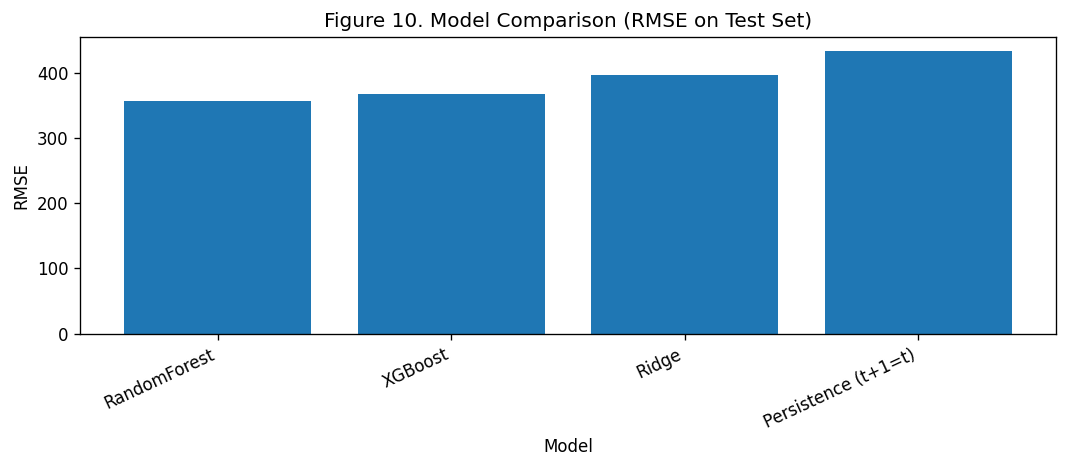

Saved: outputs/fig11_best_pred_series.png


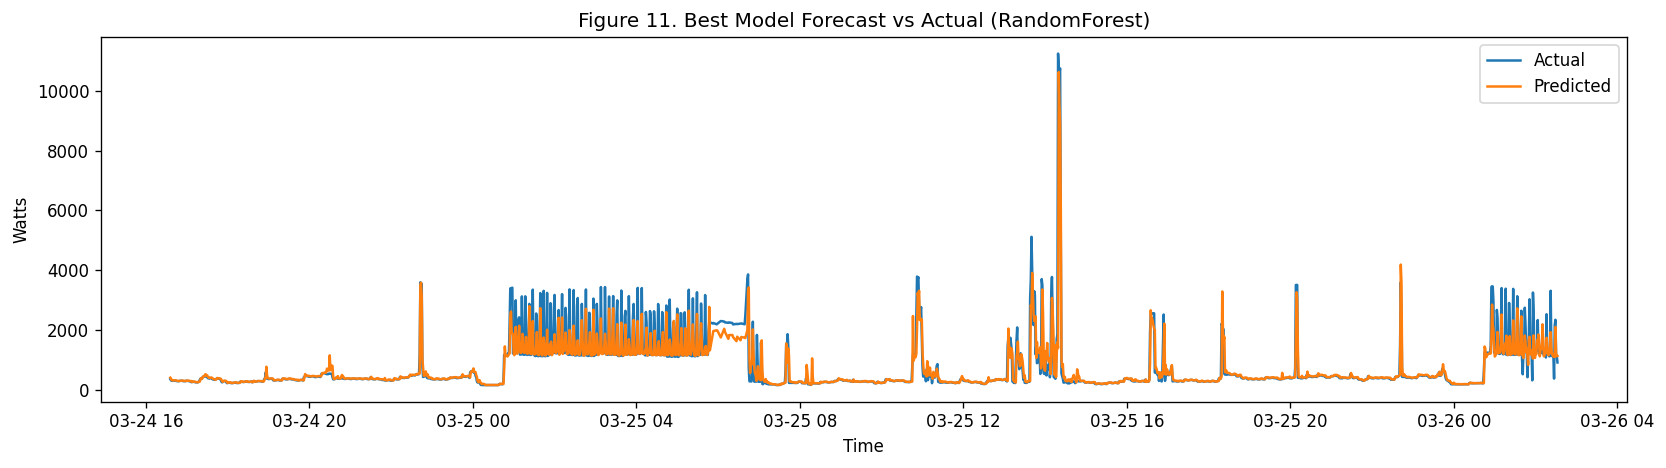

Saved: outputs/fig12_residual_hist.png


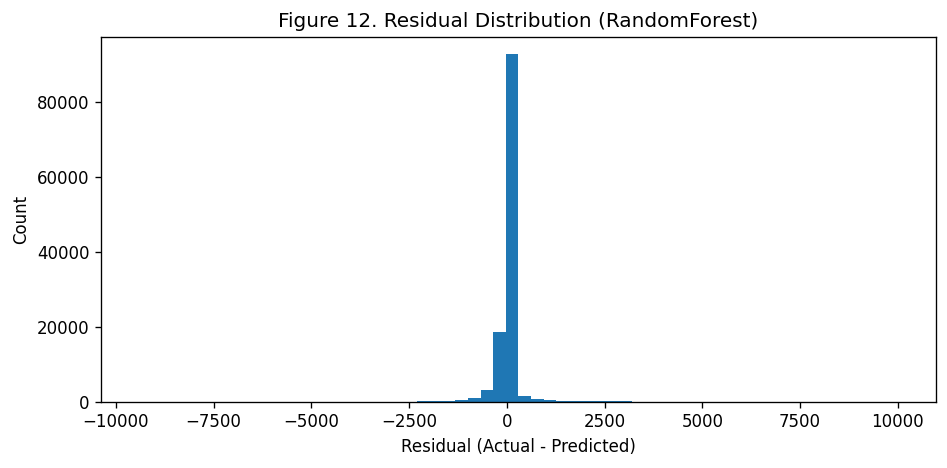

Saved: outputs/fig13_residual_vs_pred.png


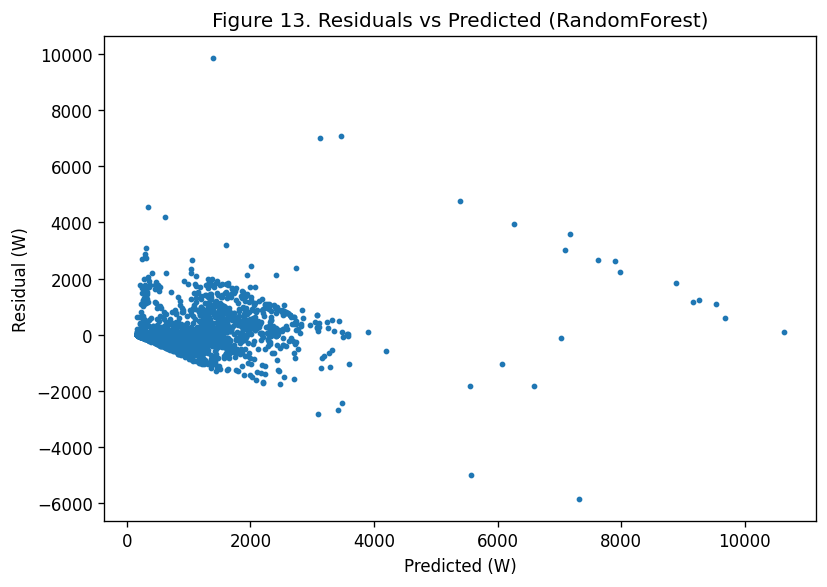

In [17]:
# Baseline: persistence
y_pred_base = X_test["Aggregate"].values
m_base = regression_report(y_test, y_pred_base, "Persistence (t+1=t)")

# Ridge
ridge = Pipeline([("scaler", StandardScaler(with_mean=False)), ("model", Ridge(alpha=1.0))])
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)
m_ridge = regression_report(y_test, pred_ridge, "Ridge")

# RandomForest (moderate)
rf = RandomForestRegressor(n_estimators=150, max_depth=18, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
m_rf = regression_report(y_test, pred_rf, "RandomForest")

# XGBoost (strong, moderate)
xgb = XGBRegressor(
    n_estimators=450,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
m_xgb = regression_report(y_test, pred_xgb, "XGBoost")

results = pd.DataFrame([m_base, m_ridge, m_rf, m_xgb]).sort_values("RMSE")
display(results)
results.to_csv(f"{OUTPUT_DIR}/model_results_table.csv", index=False)

# Figure 10: Model comparison RMSE bar chart
plt.figure(figsize=(9,4))
plt.bar(results["Model"], results["RMSE"])
plt.title("Figure 10. Model Comparison (RMSE on Test Set)")
plt.xlabel("Model"); plt.ylabel("RMSE")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
savefig("fig10_model_rmse.png")
plt.show()

# Choose best model for extra figures
best_name = results.iloc[0]["Model"]
if best_name == "XGBoost":
    best_pred = pred_xgb
elif best_name == "RandomForest":
    best_pred = pred_rf
elif best_name == "Ridge":
    best_pred = pred_ridge
else:
    best_pred = y_pred_base

# Figure 11: Best model prediction series
plot_pred_series(y_test, best_pred, f"Figure 11. Best Model Forecast vs Actual ({best_name})",
                 "fig11_best_pred_series.png", n_points=2000)

# Residuals
resid = (y_test.values - np.array(best_pred))

# Figure 12: Residual histogram
plt.figure(figsize=(8,4))
plt.hist(resid, bins=60)
plt.title(f"Figure 12. Residual Distribution ({best_name})")
plt.xlabel("Residual (Actual - Predicted)"); plt.ylabel("Count")
plt.tight_layout()
savefig("fig12_residual_hist.png")
plt.show()

# Figure 13: Residuals vs predicted scatter
plt.figure(figsize=(7,5))
plt.scatter(np.array(best_pred)[:6000], resid[:6000], s=6)
plt.title(f"Figure 13. Residuals vs Predicted ({best_name})")
plt.xlabel("Predicted (W)"); plt.ylabel("Residual (W)")
plt.tight_layout()
savefig("fig13_residual_vs_pred.png")
plt.show()

SHAP EXPLAINABILITY (XGBoost only)

In [18]:
if best_name == "XGBoost":
    sample_size = min(4000, len(X_test))
    X_shap = X_test.sample(sample_size, random_state=42)
    print("Computing SHAP values (sample =", sample_size, ") ...")
    explainer = shap.TreeExplainer(xgb)
    shap_values = explainer.shap_values(X_shap)

    # Figure 14: SHAP summary
    shap.summary_plot(shap_values, X_shap, show=False)
    plt.title("Figure 14. SHAP Summary (Global Feature Importance)")
    plt.tight_layout()
    savefig("fig14_shap_summary.png")
    plt.show()

    # Figure 15: SHAP local waterfall (single prediction)
    idx = X_shap.index[0]
    x_one = X_shap.loc[[idx]]
    sv_one = explainer.shap_values(x_one)

    shap.waterfall_plot(
        shap.Explanation(
            values=sv_one[0],
            base_values=explainer.expected_value,
            data=x_one.iloc[0],
            feature_names=x_one.columns
        ),
        show=False
    )
    plt.title("Figure 15. SHAP Waterfall (Local Explanation for One Prediction)")
    plt.tight_layout()
    savefig("fig15_shap_waterfall.png")
    plt.show()
else:
    print("Best model is not XGBoost, skipping SHAP plots.")

Best model is not XGBoost, skipping SHAP plots.


FEDERATED LEARNING (OPTIONAL) — extra figures

Federated clients: 14
{'Model': 'FedAvg Round 1', 'MAE': 474.2989290667711, 'RMSE': 924.0392786550516, 'MAPE_%': np.float64(73.11845444832483), 'R2': -0.0815976493886088}
{'Model': 'FedAvg Round 2', 'MAE': 350.9504377308668, 'RMSE': 756.399499330742, 'MAPE_%': np.float64(48.078282250599216), 'R2': 0.27525148301910485}
{'Model': 'FedAvg Round 3', 'MAE': 330.83855813161273, 'RMSE': 713.3554556091369, 'MAPE_%': np.float64(46.24172057080428), 'R2': 0.3553902888805286}
{'Model': 'FedAvg Round 4', 'MAE': 327.6363972369447, 'RMSE': 700.600331224011, 'MAPE_%': np.float64(44.629132610469), 'R2': 0.37823603770672076}
{'Model': 'FedAvg Round 5', 'MAE': 310.6046875588781, 'RMSE': 650.7865307736048, 'MAPE_%': np.float64(47.8752110906465), 'R2': 0.46350956723019887}
{'Model': 'FedAvg Round 6', 'MAE': 311.3854548849218, 'RMSE': 632.109296088341, 'MAPE_%': np.float64(51.40141390922787), 'R2': 0.4938616737867968}


,Model,MAE,RMSE,MAPE_%,R2
0,FedAvg Round 1,474.298929,924.039279,73.118454,-0.081598
1,FedAvg Round 2,350.950438,756.399499,48.078282,0.275251
2,FedAvg Round 3,330.838558,713.355456,46.241721,0.355390
3,FedAvg Round 4,327.636397,700.600331,44.629133,0.378236
4,FedAvg Round 5,310.604688,650.786531,47.875211,0.463510
5,FedAvg Round 6,311.385455,632.109296,51.401414,0.493862


Saved: outputs/fig16_fl_rmse_curve.png


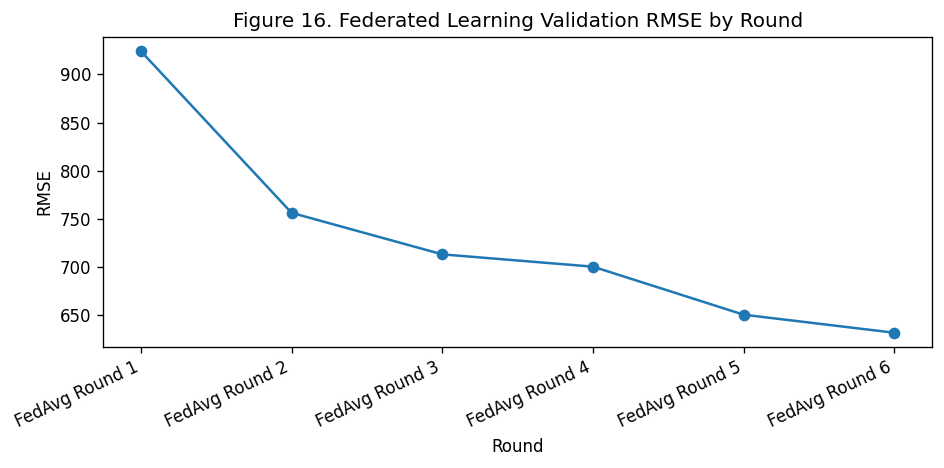

,Model,MAE,RMSE,MAPE_%,R2
0,Federated (FedAvg),152.178627,496.763995,28.079490,0.480195
1,Centralized NN,115.739115,397.533804,24.540076,0.667120


Saved: outputs/fig17_fl_vs_central_rmse.png


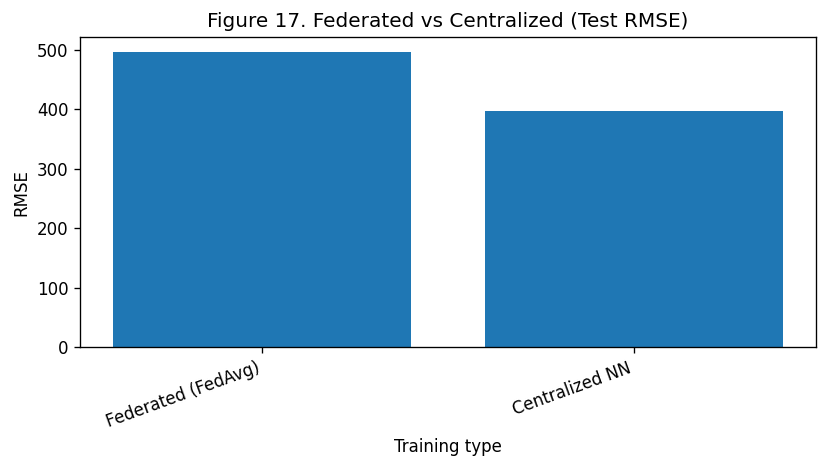

In [19]:
fl_metrics = None
central_metrics = None
hist_df = None

if RUN_FEDERATED:
    feat_df = X.copy()
    feat_df["y"] = y
    feat_df["year"] = feat_df.index.year
    feat_df["split_month"] = feat_df.index.month

    train_feat = feat_df.iloc[:train_end].copy()

    clients = []
    for (yy, mm), g in train_feat.groupby(["year", "split_month"]):
        if len(g) < 3000:
            continue
        Xc = g[FEATURE_COLS]     # ensures exact same feature set/order
        yc = g["y"]
        clients.append((f"{yy}-{mm:02d}", Xc, yc))

    print("Federated clients:", len(clients))

    if len(clients) >= 2:
        scaler = StandardScaler()
        scaler.fit(X_train[FEATURE_COLS])

        def make_tf_dataset(Xp, yp, batch=256):
            Xs = scaler.transform(Xp[FEATURE_COLS])
            ds = tf.data.Dataset.from_tensor_slices((Xs.astype(np.float32), yp.values.astype(np.float32)))
            return ds.shuffle(2000).batch(batch)

        def build_model(input_dim):
            model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(input_dim,)),
                tf.keras.layers.Dense(64, activation="relu"),
                tf.keras.layers.Dense(32, activation="relu"),
                tf.keras.layers.Dense(1)
            ])
            model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                          loss="mse",
                          metrics=[tf.keras.metrics.MeanAbsoluteError()])
            return model

        input_dim = len(FEATURE_COLS)
        global_model = build_model(input_dim)
        global_weights = global_model.get_weights()

        history = []
        for r in range(1, FL_ROUNDS+1):
            k = min(5, len(clients))
            chosen = np.random.choice(len(clients), size=k, replace=False)

            client_weights = []
            client_sizes = []

            for ci in chosen:
                _, Xc, yc = clients[ci]
                local_model = build_model(input_dim)
                local_model.set_weights(global_weights)

                ds = make_tf_dataset(Xc, yc)
                local_model.fit(ds, epochs=FL_LOCAL_EPOCHS, verbose=0)

                client_weights.append(local_model.get_weights())
                client_sizes.append(len(Xc))

            # FedAvg weighted aggregation
            w = np.array(client_sizes) / np.sum(client_sizes)
            new_weights = []
            for layer_weights in zip(*client_weights):
                layer_stack = np.stack(layer_weights, axis=0)
                new_layer = np.tensordot(w, layer_stack, axes=(0,0))
                new_weights.append(new_layer)

            global_weights = new_weights
            global_model.set_weights(global_weights)

            # validation
            Xv = scaler.transform(X_val[FEATURE_COLS]).astype(np.float32)
            pred_v = global_model.predict(Xv, verbose=0).reshape(-1)
            rep = regression_report(y_val, pred_v, name=f"FedAvg Round {r}")
            history.append(rep)
            print(rep)

        hist_df = pd.DataFrame(history)
        display(hist_df)
        hist_df.to_csv(f"{OUTPUT_DIR}/federated_history.csv", index=False)

        # Figure 16: FL validation RMSE curve
        plt.figure(figsize=(8,4))
        plt.plot(hist_df["Model"], hist_df["RMSE"], marker="o")
        plt.title("Figure 16. Federated Learning Validation RMSE by Round")
        plt.xlabel("Round"); plt.ylabel("RMSE")
        plt.xticks(rotation=25, ha="right")
        plt.tight_layout()
        savefig("fig16_fl_rmse_curve.png")
        plt.show()

        # Test eval federated
        Xt = scaler.transform(X_test[FEATURE_COLS]).astype(np.float32)
        pred_fl = global_model.predict(Xt, verbose=0).reshape(-1)
        fl_metrics = regression_report(y_test, pred_fl, "Federated (FedAvg)")

        # Centralized baseline
        central_model = build_model(input_dim)
        central_model.fit(make_tf_dataset(X_train, y_train), epochs=3, verbose=0)
        pred_c = central_model.predict(scaler.transform(X_test[FEATURE_COLS]).astype(np.float32), verbose=0).reshape(-1)
        central_metrics = regression_report(y_test, pred_c, "Centralized NN")

        compare = pd.DataFrame([fl_metrics, central_metrics])
        display(compare)
        compare.to_csv(f"{OUTPUT_DIR}/federated_vs_centralized.csv", index=False)

        # Figure 17: FL vs Centralized bar chart
        plt.figure(figsize=(7,4))
        plt.bar(compare["Model"], compare["RMSE"])
        plt.title("Figure 17. Federated vs Centralized (Test RMSE)")
        plt.xlabel("Training type"); plt.ylabel("RMSE")
        plt.xticks(rotation=20, ha="right")
        plt.tight_layout()
        savefig("fig17_fl_vs_central_rmse.png")
        plt.show()

    else:
        print("Not enough monthly partitions for FL. Skipping FL section.")
else:
    print("RUN_FEDERATED=False; skipping FL section.")


FINAL OUTPUT LISTING

In [20]:
print("\nAll output files saved in:", os.path.abspath(OUTPUT_DIR))
print(sorted(os.listdir(OUTPUT_DIR)))


All output files saved in: /content/outputs
['descriptive_stats.csv', 'federated_history.csv', 'federated_vs_centralized.csv', 'fig01_week.png', 'fig02_month.png', 'fig03_daily_profile.png', 'fig04_weekly_profile.png', 'fig05_hist_aggregate.png', 'fig06_boxplot_by_hour.png', 'fig07_corr_heatmap.png', 'fig08_appliance_share.png', 'fig09_lag_correlation.png', 'fig10_model_rmse.png', 'fig11_best_pred_series.png', 'fig12_residual_hist.png', 'fig13_residual_vs_pred.png', 'fig16_fl_rmse_curve.png', 'fig17_fl_vs_central_rmse.png', 'missing_values.csv', 'model_results_table.csv']
